In [1]:
# Goal: Direct model comparison between arnett, arnett-r0 (tigerfit) and other
import sys, collections, shelve, json, random, multiprocessing
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numba
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import astropy.constants as aconst
import astropy.units as u
import astropy.table as table
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import seaborn
import tqdm
import pandas as pd
# show all columns.. will have scrollbar anyway
pd.options.display.max_columns = None
try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataset as dataset
import snelib19odp.const as const
import snelib19odp.utils as utils
import snelib19odp.tigerfit as tigerfit
import snelib19odp.analysis.arnett as arnett
import snelib19odp.analysis.shock_fit as shock_fit

In [2]:
class DS(collections.namedtuple('DS', 'name texpl_min texpl_max vsc_peak vsc_peak_err')):
    def load(self):
        return dataset.load_dataset(self.name)
    @property
    def texpl_range(self):
        return (self.texpl_min, self.texpl_max)
    @property
    def time_valid(self):
        ds = self.load()
        t_min, _ = ds.get_bolometric('lyman').validity_range
        return np.array([[t_min, ds.transient.prior_t0+50]])
    def show(self):
        ds = self.load()
        print('== Dataset[%s] ==' % self.name)
        print('prior tpeak = %f' % ds.transient.prior_t0)
        print('texpl in [%.1f, %.1f]' % self.texpl_range)
        print('tvalid in %s [phase %s]' % (repr(self.time_valid), repr(self.time_valid-ds.transient.prior_t0)))
        
        print('vsc_peak = %f \pm %f km/s\n\n' % (self.vsc_peak, self.vsc_peak_err))

In [3]:
class Result(collections.namedtuple('Result', 'sampler result logz runner')):
    pass

Tag = collections.namedtuple('Tag', 'ds_name model params')

results = shelve.open('../products/lc-model-comparison-results.shelve')


In [4]:

class Runner(object):
    
    def __init__(self, ds, model, params, pool=None):
        lds = ds.load()
        
        texpl_range = ds.texpl_range
        time_valid = ds.time_valid
        vsc_range = (ds.vsc_peak - ds.vsc_peak_err/2, ds.vsc_peak + ds.vsc_peak_err/2)
        
        tf_prior_kwargs = {
            'vej_min': ds.vsc_peak - ds.vsc_peak_err/2,
            'vej_max': ds.vsc_peak + ds.vsc_peak_err/2,
        }
        
        shock_t_diff_env_range = (0.5, 10)
        shock_r_env_range = (0.1, 100)
        
        time_range = (float(params[0] + time_valid[0][0]), float(params[1]+lds.transient.prior_t0))
        
        if model == 'arnett':
            self.sampler_w = arnett.nested_fitting(lds, time_range=time_range, texpl_range=texpl_range, time_valid=time_valid, sampler='dynamic_nested')
            self.sampler = self.sampler_w.sampler
        elif model == 'arnett_alt':
            self.sampler_w = arnett.nested_fitting_alt(lds, time_range=time_range, vsc_range=vsc_range, texpl_range=texpl_range, time_valid=time_valid, pool=pool)
            self.sampler = self.sampler_w.sampler
        elif model == 'arnett_r0':
            self.sampler_w = arnett.nested_fitting_nico_r0(lds, time_range=time_range, vsc_range=vsc_range, texpl_range=texpl_range, time_valid=time_valid, pool=pool)
            self.sampler = self.sampler_w.sampler
        elif model == 'tigerfit':
            self.sampler = tigerfit.nested_fitting(lds, time_range=time_range, time_valid=time_valid, texpl_range=texpl_range, prior_kwargs=tf_prior_kwargs)
        elif model == 'tigerfit_e_th':
            self.sampler = tigerfit.nested_fitting(lds, time_range=time_range, time_valid=time_valid, texpl_range=texpl_range, include_e_thermal=True, prior_kwargs=tf_prior_kwargs)
        elif model == 'tigerfit_trapped':
            self.sampler = tigerfit.nested_fitting(lds, time_range=time_range, time_valid=time_valid, texpl_range=texpl_range, prior_kwargs=tf_prior_kwargs, gamma_trapped=True)
        elif model == 'piro2020_tdiff':
            texpl_range = (ds.texpl_range[0]-5, ds.texpl_range[1])
            self.sampler_w = shock_fit.nested_fitting_shock_arnett_tdiff(lds, time_range=time_range, vsc_range=vsc_range, texpl_range=texpl_range, time_valid=time_valid, r_env_range=shock_r_env_range, t_diff_env_range=shock_t_diff_env_range, sampler='dynamic_nested')
            self.sampler = self.sampler_w.sampler
        elif model == 'piro2020_me':
            texpl_range = (ds.texpl_range[0]-5, ds.texpl_range[1])
            self.sampler_w = shock_fit.nested_fitting_shock_arnett_me(lds, time_range=time_range, vsc_range=vsc_range, texpl_range=texpl_range, time_valid=time_valid, r_env_range=shock_r_env_range, sampler='dynamic_nested')
            self.sampler = self.sampler_w.sampler
    def run(self):
        self.sampler.run_nested()
        logz = self.sampler.results.logz[-1]
        return Result(sampler=self.sampler, result=self.sampler.results, logz=logz, runner=self)

In [5]:
# Setup all the datasets
# 1/np.sqrt(0.6) is the constant in eqn. 10 (relating scale velocity to mean velocity)
# also known as I_K/I_M in Arnett parlence and ranges from 0.77 to 0.3
sn2019odp = DS('SN2019odp_phot', 58712.48, 58716.38, 10912/np.sqrt(0.6), 1435/np.sqrt(0.6))
sn2019odp.show()
ptf13bvn = DS('iPTF13bvn', 56458.3-0.8, 56458.3+0.8, 8000/np.sqrt(0.6), 1000/np.sqrt(0.6))
ptf13bvn.show()
sn1998bw = DS('SN1998bw', 50928.908, 50928.909, 19500/np.sqrt(0.6), 1700/np.sqrt(0.6))
sn1998bw.show()
sn2008d = DS('SN2008D', 54474.563, 54474.565, 8000/np.sqrt(0.6), 1000/np.sqrt(0.6))
sn2008d.show()

== Dataset[SN2019odp_phot] ==
prior tpeak = 58734.000000
texpl in [58712.5, 58716.4]


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


tvalid in array([[58717.3948958, 58784.       ]]) [phase array([[-16.6051042,  50.       ]])]
vsc_peak = 14087.331425 \pm 1852.577034 km/s


== Dataset[iPTF13bvn] ==
prior tpeak = 56477.000000
texpl in [56457.5, 56459.1]


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the f

tvalid in array([[56460.383, 56527.   ]]) [phase array([[-16.617,  50.   ]])]
vsc_peak = 10327.955590 \pm 1290.994449 km/s


== Dataset[SN1998bw] ==
prior tpeak = 50945.000000
texpl in [50928.9, 50928.9]
tvalid in array([[50930.63000488, 50995.        ]]) [phase array([[-14.36999512,  50.        ]])]
vsc_peak = 25174.391750 \pm 2194.690563 km/s


== Dataset[SN2008D] ==
prior tpeak = 54493.000000
texpl in [54474.6, 54474.6]


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


tvalid in array([[54475.41335, 54543.     ]]) [phase array([[-17.58665,  50.     ]])]
vsc_peak = 10327.955590 \pm 1290.994449 km/s




/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


In [6]:
#tmin_grid = [0, 1, 2, 4, 6]
tmin_grid = [2, 4, 6, 8, 10]
#tmax_grid = [10, 15, 20, 25, 30, 40, 50, 60, 70, 80]
#tmax_grid = [10]
tmax_grid = [25, 30, 35, 40]#20, 25,30]
#models = ['arnett', 'tigerfit', 'tigerfit_e_th', 'tigerfit_trapped']
#models = ['arnett', 'tigerfit', 'tigerfit_trapped']
#models = ['piro2020_me']
#models = ['arnett_alt', 'arnett']
models = ['arnett_r0', 'arnett', 'arnett_alt', 'tigerfit']
ds_es = [sn2019odp, ptf13bvn, sn1998bw, sn2008d]
#ds_es = [ptf13bvn]

In [ ]:
random.shuffle(tmin_grid)
random.shuffle(tmax_grid)
random.shuffle(models)
random.shuffle(ds_es)
for tmax in tmax_grid:
    for tmin in tmin_grid:
        for ds in ds_es:
            for model in models:
                if model in ['arnett', 'tigerfit_trapped', 'arnett_alt'] and tmax > 40:
                    continue
                params = (tmin, tmax)
                tag = Tag(ds.name, model, params=params)
                new_tag = json.dumps([tag.ds_name, tag.model, tag.params])
                if new_tag in results:
                    print('%s already run. Skipping.' % repr(tag))
                    continue
                else:
                    print('Running %s' % repr(tag))
                try:
                    #with multiprocessing.Pool(6) as pool:
                    if True:
                        pool = None
                        run = Runner(ds, model, params=params, pool=pool)
                        result = run.run()
                        results[new_tag] = result
                except np.linalg.LinAlgError:
                    continue

Running Tag(ds_name='iPTF13bvn', model='arnett', params=(8, 30))


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
  0%|          | 1/12000 [00:00<22:39,  8.83it/s]

Time Range: (56468.383, 56507.0)


100%|██████████| 12000/12000 [00:32<00:00, 370.16it/s]
20798it [6:10:22,  1.07s/it, batch: 7 | bound: 32829 | nc: 1 | ncall: 51344228 | eff(%):  0.041 | loglstar: -12.619 < -2.398 < -5.816 | logz: -15.048 +/-  0.170 | stop:  0.877]             


Tag(ds_name='iPTF13bvn', model='arnett_r0', params=(8, 30)) already run. Skipping.
Running Tag(ds_name='iPTF13bvn', model='arnett_alt', params=(8, 30))


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
  0%|          | 1/12000 [00:00<22:35,  8.85it/s]

Time Range: (56468.383, 56507.0)


100%|██████████| 12000/12000 [00:32<00:00, 371.65it/s]
21070it [24:25, 14.38it/s, +2000 | bound: 275 | nc: 1 | ncall: 951461 | eff(%):  2.425 | loglstar:   -inf < -2.628 <    inf | logz: -14.755 +/-  0.194 | dlogz:  0.002 >  2.009]


Running Tag(ds_name='iPTF13bvn', model='tigerfit', params=(8, 30))


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
  0%|          | 0/12000 [00:00<?, ?it/s]/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
100%|██████████| 12000/12000 [00:32<00:00, 371.23it/s]
10773it [05:16, 34.00it/s, +1000 | bound: 154 | nc: 1 | ncall: 282029 | eff(%):  4.174 | loglstar:   -inf < -3.623 <    inf | logz: -14.700 +/-  0.174 | dlogz:  0.001 >  1.009]


Tag(ds_name='SN2019odp_phot', model='arnett', params=(8, 30)) already run. Skipping.
Tag(ds_name='SN2019odp_phot', model='arnett_r0', params=(8, 30)) already run. Skipping.
Running Tag(ds_name='SN2019odp_phot', model='arnett_alt', params=(8, 30))


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
  0%|          | 1/12000 [00:00<36:48,  5.43it/s]

Time Range: (58725.3948958, 58764.0)


100%|██████████| 12000/12000 [01:18<00:00, 153.51it/s]
9902it [01:22, 120.21it/s, +2000 | bound: 8 | nc: 1 | ncall: 95046 | eff(%): 12.522 | loglstar:   -inf < -0.120 <    inf | logz: -5.689 +/-  0.080 | dlogz:  0.001 >  2.009]


Running Tag(ds_name='SN2019odp_phot', model='tigerfit', params=(8, 30))


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
100%|██████████| 12000/12000 [01:18<00:00, 153.10it/s]
6746it [00:41, 162.34it/s, +1000 | bound: 14 | nc: 1 | ncall: 56975 | eff(%): 13.595 | loglstar:   -inf < -0.157 <    inf | logz: -6.789 +/-  0.112 | dlogz:  0.001 >  1.009]
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
  0%|          | 19/12000 [00:00<01:03, 189.48it/s]

Tag(ds_name='SN1998bw', model='arnett', params=(8, 30)) already run. Skipping.
Tag(ds_name='SN1998bw', model='arnett_r0', params=(8, 30)) already run. Skipping.
Running Tag(ds_name='SN1998bw', model='arnett_alt', params=(8, 30))
Time Range: (50938.63000488281, 50975.0)


100%|██████████| 12000/12000 [00:30<00:00, 391.69it/s]
9181it [01:39, 92.44it/s, +2000 | bound: 12 | nc: 1 | ncall: 107199 | eff(%): 10.430 | loglstar:   -inf < -1.073 <    inf | logz: -6.799 +/-  0.120 | dlogz:  0.002 >  2.009]
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
  0%|          | 19/12000 [00:00<01:03, 188.70it/s]

Running Tag(ds_name='SN1998bw', model='tigerfit', params=(8, 30))


100%|██████████| 12000/12000 [00:30<00:00, 395.16it/s]
6621it [00:48, 135.42it/s, +1000 | bound: 23 | nc: 1 | ncall: 70145 | eff(%): 10.865 | loglstar:   -inf < -1.228 <    inf | logz: -7.969 +/-  0.131 | dlogz:  0.001 >  1.009]


Tag(ds_name='SN2008D', model='arnett', params=(8, 30)) already run. Skipping.
Tag(ds_name='SN2008D', model='arnett_r0', params=(8, 30)) already run. Skipping.
Running Tag(ds_name='SN2008D', model='arnett_alt', params=(8, 30))


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
  0%|          | 1/12000 [00:00<22:10,  9.02it/s]

Time Range: (54483.41335, 54523.0)


100%|██████████| 12000/12000 [00:29<00:00, 400.55it/s]
15493it [05:52, 43.91it/s, +2000 | bound: 53 | nc: 1 | ncall: 229912 | eff(%):  7.609 | loglstar:   -inf < -0.247 <    inf | logz: -9.097 +/-  0.133 | dlogz:  0.002 >  2.009]


Running Tag(ds_name='SN2008D', model='tigerfit', params=(8, 30))


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
100%|██████████| 12000/12000 [00:29<00:00, 400.08it/s]
9095it [02:16, 66.63it/s, +1000 | bound: 66 | nc: 1 | ncall: 135965 | eff(%):  7.425 | loglstar:   -inf < -0.425 <    inf | logz: -9.642 +/-  0.153 | dlogz:  0.001 >  1.009]


Running Tag(ds_name='iPTF13bvn', model='arnett', params=(10, 30))


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
  0%|          | 1/12000 [00:00<22:12,  9.00it/s]

Time Range: (56470.383, 56507.0)


100%|██████████| 12000/12000 [00:32<00:00, 371.56it/s]
7802it [3:29:55, 31.12s/it, batch: 0 | bound: 19302 | nc: 105721 | ncall: 30196216 | eff(%):  0.026 | loglstar:   -inf < -4.367 <    inf | logz: -15.222 +/-  0.172 | dlogz:  0.022 >  0.010]

In [9]:
def get_ds(tag):
    if tag.ds_name == 'SN2019odp_phot':
        return sn2019odp
    elif tag.ds_name == 'iPTF13bvn':
        return ptf13bvn
    elif tag.ds_name == 'SN1998bw':
        return sn1998bw
    elif tag.ds_name == 'SN2008D':
        return sn2008d
    else:
        return None

def extract_mni(tag, r):
    "return mni [Msol]"
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    mean, cov = dyfunc.mean_and_cov(samples, weights)
    trace = dyfunc.resample_equal(samples, weights)
    if tag.model in ['arnett', 'arnett_alt', 'arnett_r0']:
        return trace[:,0]
    elif tag.model in ['tigerfit', 'tigerfit_e_th', 'tigerfit_trapped']:
        return trace[:,0]
    else:
        raise NotImplementedError()
    #else:
    #    return (np.nan, np.nan, np.array([]))
    
def extract_mej(tag, r):
    "returns td [d], mej [Msol]"
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    ds = get_ds(tag)
    
    if tag.model == 'arnett':
        td = trace[:,1] * u.day.to(u.s)
        opacity = 0.07
        beta = 13.8
        c=2.99792458e10
        v_sc = np.random.normal(ds.vsc_peak, ds.vsc_peak_err, size=len(td)) * u.km.to(u.cm)
        m_ej = td**2 * beta * c * v_sc / 2 / opacity * u.g.to(u.Msun)
        return trace[:,1], m_ej
    elif tag.model == 'arnett_r0':
        td = trace[:,1] * u.day.to(u.s)
        opacity = 0.07
        beta = 13.8
        c=2.99792458e10
        v_sc = trace[:,5]
        m_ej = td**2 * beta * c * v_sc / 2 / opacity * u.g.to(u.Msun)
        return trace[:,1], m_ej
    elif tag.model == 'arnett_alt':
        m_ej = trace[:,1]
        return np.nan*np.empty_like(m_ej), m_ej
    elif tag.model in ['tigerfit', 'tigerfit_e_th', 'tigerfit_trapped']:
        td = trace[:,1] * u.day.to(u.s)
        opacity = 0.07
        beta = 13.8
        c=2.99792458e10
        #v_sc = np.random.normal(ds.vsc_peak, ds.vsc_peak_err, size=len(td)) * u.km.to(u.cm)
        v_sc = trace[:,3] * u.km.to(u.cm)
        m_ej = td**2 * beta * c * v_sc / 2 / opacity * u.g.to(u.Msun)
        return trace[:,1], m_ej
    else:
        raise NotImplementedError()

def extract_ekin(tag, r):
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    ds = get_ds(tag)
    
    if tag.model == 'arnett_alt':
        m_ej = trace[:,1] # [Msol]
        v_sc = trace[:,2] # [km/s]
        # we need * v_m^2 -> * \xi^2 -> * 0.6 = 3/5
        e_kin = m_ej * u.Msun.to(u.g) / 2 * (v_sc * u.km.to(u.cm))**2 * 0.6 / 1e51 # [foe]
    elif tag.model == 'arnett_r0':
        td = trace[:,1] * u.day.to(u.s)
        opacity = 0.07
        beta = 13.8
        c=2.99792458e10
        
        v_sc = trace[:,5] # [cm/s]
        # we need * v_m^2 -> * \xi^2 -> * 0.6 = 3/5
        e_kin = td**2 * beta * c * v_sc**3 * 0.6 / 4 / opacity / 1e51 # [foe]
    elif tag.model == 'arnett':
        td = trace[:,1] * u.day.to(u.s)
        opacity = 0.07
        beta = 13.8
        c=2.99792458e10
        v_sc = np.random.normal(ds.vsc_peak, ds.vsc_peak_err, size=len(td)) * u.km.to(u.cm)
        # we need * v_m^2 -> * \xi^2 -> * 0.6 = 3/5
        e_kin = td**2 * beta * c * v_sc**3 * 0.6 / 4 / opacity / 1e51 # [foe]
    elif tag.model == 'tigerfit':
        e_kin = np.nan * np.empty_like(trace[:,1])
    else:
        raise NotImplementedError()
    return e_kin
    
def extract_r0(tag, r):
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    ds = get_ds(tag)
    
    if tag.model in ['tigerfit', 'tigerfit_e_th', 'tigerfit_trapped']:
        r0 = trace[:,2] * 1e15 * u.cm.to(u.Rsun)
        rn,rp = np.quantile(r0, [0.16, 0.84])
        mean = np.nanmean(r0)
        return mean, np.nanstd(r0), (mean-rn), (rp-mean)
    elif tag.model == 'arnett_r0':
        r0 = trace[:,3] * u.cm.to(u.Rsun)
        rn,rp = np.quantile(r0, [0.16, 0.84])
        mean = np.nanmean(r0)
        return mean, np.nanstd(r0), (mean-rn), (rp-mean)
    else:
        raise NotImplementedError()

* Processing: Tag(ds_name='iPTF13bvn', model='arnett_r0', params=[6, 25])
	Samples: (25813, 6)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1077: UserWarning: Dataset has 0 variance; skipping density estimate.

* Processing: Tag(ds_name='iPTF13bvn', model='arnett', params=[6, 25])
	Samples: (25465, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


* Processing: Tag(ds_name='SN1998bw', model='arnett_r0', params=[6, 25])
	Samples: (17092, 6)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1077: UserWarning: Dataset has 0 variance; skipping density estimate.

* Processing: Tag(ds_name='SN1998bw', model='arnett', params=[6, 25])
	Samples: (23083, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


* Processing: Tag(ds_name='SN2008D', model='arnett_r0', params=[6, 25])
	Samples: (21419, 6)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpr

* Processing: Tag(ds_name='SN2008D', model='arnett', params=[6, 25])
	Samples: (20925, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


* Processing: Tag(ds_name='SN2019odp_phot', model='arnett_r0', params=[6, 25])
	Samples: (18178, 6)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1077: UserWarning: Dataset has 0 variance; skipping density estimate.

* Processing: Tag(ds_name='SN2019odp_phot', model='arnett', params=[6, 25])
	Samples: (24035, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


* Processing: Tag(ds_name='iPTF13bvn', model='arnett_r0', params=[4, 25])
	Samples: (26092, 6)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1077: UserWarning: Dataset has 0 variance; skipping density estimate.

* Processing: Tag(ds_name='iPTF13bvn', model='arnett', params=[4, 25])
	Samples: (19151, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


* Processing: Tag(ds_name='SN1998bw', model='arnett_r0', params=[4, 25])
	Samples: (17274, 6)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1077: UserWarning: Dataset has 0 variance; skipping density estimate.

* Processing: Tag(ds_name='SN1998bw', model='arnett', params=[4, 25])
	Samples: (22917, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


* Processing: Tag(ds_name='SN2008D', model='arnett_r0', params=[4, 25])
	Samples: (21669, 6)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1077: UserWarning: Dataset has 0 variance; skipping density estimate.

* Processing: Tag(ds_name='SN2008D', model='arnett', params=[4, 25])
	Samples: (20657, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


* Processing: Tag(ds_name='SN2019odp_phot', model='arnett_r0', params=[4, 25])
	Samples: (18715, 6)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1077: UserWarning: Dataset has 0 variance; skipping density estimate.

* Processing: Tag(ds_name='SN2019odp_phot', model='arnett', params=[4, 25])
	Samples: (25095, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


* Processing: Tag(ds_name='iPTF13bvn', model='arnett_r0', params=[6, 30])
	Samples: (26111, 6)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1077: UserWarning: Dataset has 0 variance; skipping density estimate.

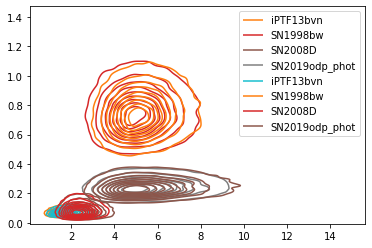

In [11]:
# construct the Mej-Mni diagram
d = {'tag': [], 'logz': [], 'model': [], 'tmin': [], 'tmax': [], 'duration': [], 'dataset': [], 'Mni': [], 'Mni_err': [], 'Mni_err_neg': [], 'Mni_err_pos': [], 'Mej': [], 'Mej_err': [], 'Mej_err_neg': [], 'Mej_err_pos': [], 'Ek': [], 'Ek_err': [], 'R0': [], 'R0_err': [], 'R0_err_n': [], 'R0_err_p': [], 't_d': [], 't_d_err': []}
seen = set([])
colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
for k in results.keys():
    v = results[k]
    
    # decode the tag
    tag = json.loads(k)
    rtag = Tag(*tag)
    print(f"* Processing: {repr(rtag)}")
    ds = get_ds(rtag)
    
    # the Piro2021 models here are not really relevant
    if rtag.model in ['piro2020_me', 'piro2020_tdiff']:
        continue
    
    print(f"\tSamples: {repr(v.sampler.results.samples.shape)}")
    
    d['tag'].append(k)
    d['logz'].append(v.logz)
    #d['tmin'].append(tag[2][0])
    d['tmax'].append(tag[2][1])
    time_range = (float(rtag.params[0] + ds.time_valid[0][0]), float(rtag.params[1]+ds.load().transient.prior_t0))
    d['tmin'].append(rtag.params[0] + ds.time_valid[0][0] - ds.load().transient.prior_t0)
    d['duration'].append(time_range[1] - time_range[0])
    d['dataset'].append(tag[0])
    d['model'].append(tag[1])
    mni = extract_mni(rtag, v)
    d['Mni'].append(mni)
    #d['Mni_err'].append(mni_err)
    #mni_perc = np.percentile(mni_trace, [15.9, 50, 84.1])
    #d['Mni_err_neg'].append(mni_perc[1]-mni_perc[0])
    #d['Mni_err_pos'].append(mni_perc[2]-mni_perc[1])
    
    ek = extract_ekin(rtag, v)
    d['Ek'].append(ek)
    #d['Ek_err'].append(ek_err)
    
    td, mej = extract_mej(rtag, v)
    d['Mej'].append(mej)
    #d['Mej_err'].append(mej_err)
    #mej_perc = np.percentile(mej_trace, [15.9, 50, 84.1])
    #d['Mej_err_neg'].append(mej_perc[1]-mej_perc[0])
    #d['Mej_err_pos'].append(mej_perc[2]-mej_perc[1])
    
    d['t_d'].append(td)
    #d['t_d_err'].append(td_err)
    #r0, r0_err, r0_en, r0_ep = extract_r0(rtag, v)
    #d['R0'].append(r0)
    #d['R0_err'].append(r0_err)
    #d['R0_err_n'].append(r0_en)
    #d['R0_err_p'].append(r0_ep)
    
    # choose the next colormap
    cmap = colormaps.pop(0)
    colormaps.append(cmap)
    
    #plt.hexbin(mej, mni, label=tag[0], cmap=cmap)
    #plt.colorbar(cmap, label=tag[0])
    seaborn.kdeplot(mej, mni, label=tag[0])
    
plt.legend()
#import pandas as pd
#df = pd.DataFrame(data=d)
#df

In [14]:
# construct the Mej-Mni diagram
#d = {'tag': [], 'logz': [], 'model': [], 'tmin': [], 'tmax': [], 'duration': [], 'dataset': [], 'Mni': [], 'Mni_err': [], 'Mni_err_neg': [], 'Mni_err_pos': [], 'Mej': [], 'Mej_err': [], 'Mej_err_neg': [], 'Mej_err_pos': [], 'Ek': [], 'Ek_err': [], 'R0': [], 'R0_err': [], 'R0_err_n': [], 'R0_err_p': [], 't_d': [], 't_d_err': []}
#seen = set([])
#colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

# transient -> d
data = {}

# colormapping
O2C = {
    'SN2019odp_phot': 'tab:blue',
    'SN2008D': 'tab:red',
    'iPTF13bvn': 'tab:pink',
    'SN2002ap': 'tab:brown',
    'SN1998bw': 'tab:orange'
}

# extract the data seperated by transient
for k in results.keys():
    v = results[k]
    
    # decode the tag
    tag = json.loads(k)
    rtag = Tag(*tag)
    print(f"* Processing: {repr(rtag)}")
    ds = get_ds(rtag)
    
    # the Piro2021 models here are not really relevant
    if rtag.model in ['piro2020_me', 'piro2020_tdiff']:
        continue
        
    # something wrong with the arnett_r0 model..
    if rtag.model in ['arnett_r0']:
        continue
    
    print(f"\tSamples: {repr(v.sampler.results.samples.shape)}")
    
    ds_name = tag[0]
    if ds_name not in data:
        data[ds_name] = {'tag': [], 'logz': [], 'model': [], 'tmin': [], 'tmax': [], 'duration': [], 'dataset': [], 'Mni': [], 'Mni_err': [], 'Mni_err_neg': [], 'Mni_err_pos': [], 'Mej': [], 'Mej_err': [], 'Mej_err_neg': [], 'Mej_err_pos': [], 'Ek': [], 'Ek_err': [], 'R0': [], 'R0_err': [], 'R0_err_n': [], 'R0_err_p': [], 't_d': [], 't_d_err': []}
    d = data[ds_name]
    
    d['tag'].append(k)
    d['logz'].append(v.logz)
    #d['tmin'].append(tag[2][0])
    d['tmax'].append(tag[2][1])
    time_range = (float(rtag.params[0] + ds.time_valid[0][0]), float(rtag.params[1]+ds.load().transient.prior_t0))
    d['tmin'].append(rtag.params[0] + ds.time_valid[0][0] - ds.load().transient.prior_t0)
    d['duration'].append(time_range[1] - time_range[0])
    d['dataset'].append(tag[0])
    d['model'].append(tag[1])
    mni = extract_mni(rtag, v)
    d['Mni'].append(mni)
    #d['Mni_err'].append(mni_err)
    #mni_perc = np.percentile(mni_trace, [15.9, 50, 84.1])
    #d['Mni_err_neg'].append(mni_perc[1]-mni_perc[0])
    #d['Mni_err_pos'].append(mni_perc[2]-mni_perc[1])
    
    ek = extract_ekin(rtag, v)
    d['Ek'].append(ek)
    #d['Ek_err'].append(ek_err)
    
    td, mej = extract_mej(rtag, v)
    d['Mej'].append(mej)
    print('\tMej: ', repr(np.percentile(mej, [15.9, 50, 84.1])))
    #d['Mej_err'].append(mej_err)
    #mej_perc = np.percentile(mej_trace, [15.9, 50, 84.1])
    #d['Mej_err_neg'].append(mej_perc[1]-mej_perc[0])
    #d['Mej_err_pos'].append(mej_perc[2]-mej_perc[1])
    
    d['t_d'].append(td)
    #d['t_d_err'].append(td_err)
    #r0, r0_err, r0_en, r0_ep = extract_r0(rtag, v)
    #d['R0'].append(r0)
    #d['R0_err'].append(r0_err)
    #d['R0_err_n'].append(r0_en)
    #d['R0_err_p'].append(r0_ep)
    
    # choose the next colormap
    #cmap = colormaps.pop(0)
    #colormaps.append(cmap)
    
    #plt.hexbin(mej, mni, label=tag[0], cmap=cmap)
    #plt.colorbar(cmap, label=tag[0])
    #seaborn.kdeplot(mej, mni, label=tag[0])
#for ds_name in data.keys():
#    d = data[ds_name]
#    mej = np.concatenate(d['Mej'])
#    mni = np.concatenate(d['Mni'])
    #seaborn.kdeplot(mej, mni, label=ds_name, color=O2C[ds_name])
#    H, ybins, xbins = np.histogram2d(mni, mej, bins=50)
    #plt.contour(H,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3, label=ds_name, color=O2C[ds_name])

#plt.legend()
#plt.xlabel('Ejecta Mass [Msol]')
#plt.ylabel('Nickel Mass [Msol]')

#plt.legend()
#import pandas as pd
#df = pd.DataFrame(data=d)
#df

* Processing: Tag(ds_name='iPTF13bvn', model='arnett_r0', params=[6, 25])
* Processing: Tag(ds_name='iPTF13bvn', model='arnett', params=[6, 25])
	Samples: (25465, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([1.30767417, 1.68063325, 2.11014999])
* Processing: Tag(ds_name='SN1998bw', model='arnett_r0', params=[6, 25])
* Processing: Tag(ds_name='SN1998bw', model='arnett', params=[6, 25])
	Samples: (23083, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([4.10666   , 5.06819452, 6.17644472])
* Processing: Tag(ds_name='SN2008D', model='arnett_r0', params=[6, 25])
* Processing: Tag(ds_name='SN2008D', model='arnett', params=[6, 25])
	Samples: (20925, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([1.98437426, 2.47649124, 3.04720914])
* Processing: Tag(ds_name='SN2019odp_phot', model='arnett_r0', params=[6, 25])
* Processing: Tag(ds_name='SN2019odp_phot', model='arnett', params=[6, 25])
	Samples: (24035, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([4.16265007, 5.35184921, 6.90706429])
* Processing: Tag(ds_name='iPTF13bvn', model='arnett_r0', params=[4, 25])
* Processing: Tag(ds_name='iPTF13bvn', model='arnett', params=[4, 25])
	Samples: (19151, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([1.3666941 , 1.72784835, 2.14844338])
* Processing: Tag(ds_name='SN1998bw', model='arnett_r0', params=[4, 25])
* Processing: Tag(ds_name='SN1998bw', model='arnett', params=[4, 25])
	Samples: (22917, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([4.31355842, 5.22075461, 6.29108372])
* Processing: Tag(ds_name='SN2008D', model='arnett_r0', params=[4, 25])
* Processing: Tag(ds_name='SN2008D', model='arnett', params=[4, 25])
	Samples: (20657, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([1.90792885, 2.35544248, 2.88322521])
* Processing: Tag(ds_name='SN2019odp_phot', model='arnett_r0', params=[4, 25])
* Processing: Tag(ds_name='SN2019odp_phot', model='arnett', params=[4, 25])
	Samples: (25095, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([4.23055078, 5.43266909, 7.02760464])
* Processing: Tag(ds_name='iPTF13bvn', model='arnett_r0', params=[6, 30])
* Processing: Tag(ds_name='SN2008D', model='arnett_r0', params=[8, 30])
* Processing: Tag(ds_name='SN2008D', model='arnett', params=[8, 30])
	Samples: (20174, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([1.83892835, 2.35709431, 2.9615531 ])
* Processing: Tag(ds_name='SN1998bw', model='arnett_r0', params=[8, 30])
* Processing: Tag(ds_name='SN1998bw', model='arnett', params=[8, 30])
	Samples: (22833, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([3.5047697 , 4.59032618, 5.76031032])
* Processing: Tag(ds_name='SN2019odp_phot', model='arnett_r0', params=[8, 30])
* Processing: Tag(ds_name='SN2019odp_phot', model='arnett', params=[8, 30])
	Samples: (15460, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([3.79290752, 4.92050209, 6.32715453])
* Processing: Tag(ds_name='iPTF13bvn', model='arnett_r0', params=[8, 30])
* Processing: Tag(ds_name='iPTF13bvn', model='arnett', params=[8, 30])
	Samples: (20798, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([1.07138867, 1.48602281, 1.94011153])
* Processing: Tag(ds_name='iPTF13bvn', model='arnett_alt', params=[8, 30])
	Samples: (23070, 4)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([1.2060874 , 1.56760479, 1.95397145])
* Processing: Tag(ds_name='iPTF13bvn', model='tigerfit', params=[8, 30])
	Samples: (11773, 5)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([1.17334502, 1.53761344, 1.91996459])
* Processing: Tag(ds_name='SN2019odp_phot', model='arnett_alt', params=[8, 30])
	Samples: (11902, 4)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([4.09338698, 5.05926647, 6.26580213])
* Processing: Tag(ds_name='SN2019odp_phot', model='tigerfit', params=[8, 30])
	Samples: (7746, 5)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([4.13702829, 5.12372517, 6.24918418])
* Processing: Tag(ds_name='SN1998bw', model='arnett_alt', params=[8, 30])
	Samples: (11181, 4)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([3.70050884, 4.74779633, 5.85017753])
* Processing: Tag(ds_name='SN1998bw', model='tigerfit', params=[8, 30])
	Samples: (7621, 5)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([3.68048673, 4.68712993, 5.74736409])
* Processing: Tag(ds_name='SN2008D', model='arnett_alt', params=[8, 30])
	Samples: (17493, 4)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([1.98376839, 2.4480605 , 2.95423313])
* Processing: Tag(ds_name='SN2008D', model='tigerfit', params=[8, 30])
	Samples: (10095, 5)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([1.99174619, 2.44302408, 2.91592132])
* Processing: Tag(ds_name='iPTF13bvn', model='arnett', params=[10, 30])
	Samples: (20257, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([0.9077622 , 1.40351992, 1.91545068])
* Processing: Tag(ds_name='iPTF13bvn', model='arnett_r0', params=[10, 30])
* Processing: Tag(ds_name='iPTF13bvn', model='arnett_alt', params=[10, 30])
	Samples: (21780, 4)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([1.10442152, 1.51756276, 1.95465364])
* Processing: Tag(ds_name='iPTF13bvn', model='tigerfit', params=[10, 30])
	Samples: (11693, 5)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([1.04237023, 1.4863401 , 1.89489921])
* Processing: Tag(ds_name='SN2019odp_phot', model='arnett', params=[10, 30])
	Samples: (17228, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([3.46613394, 4.67568691, 6.11851608])
* Processing: Tag(ds_name='SN2019odp_phot', model='arnett_r0', params=[10, 30])
* Processing: Tag(ds_name='SN2019odp_phot', model='arnett_alt', params=[10, 30])
	Samples: (11404, 4)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([3.79943145, 4.82965381, 6.05679346])
* Processing: Tag(ds_name='SN2019odp_phot', model='tigerfit', params=[10, 30])
	Samples: (7738, 5)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([3.86613429, 4.90709925, 6.07069034])
* Processing: Tag(ds_name='SN1998bw', model='arnett', params=[10, 30])
	Samples: (25171, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([2.91956187, 4.31479792, 5.63061142])
* Processing: Tag(ds_name='SN1998bw', model='arnett_r0', params=[10, 30])
* Processing: Tag(ds_name='SN1998bw', model='arnett_alt', params=[10, 30])
	Samples: (10550, 4)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([3.24182492, 4.55283826, 5.78657744])
* Processing: Tag(ds_name='SN2008D', model='arnett', params=[10, 30])
	Samples: (16826, 3)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([1.72465842, 2.2958706 , 2.95837879])
* Processing: Tag(ds_name='SN2008D', model='arnett_r0', params=[10, 30])
* Processing: Tag(ds_name='SN2008D', model='arnett_alt', params=[10, 30])
	Samples: (16752, 4)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([1.84651859, 2.38484869, 2.94883281])
* Processing: Tag(ds_name='SN2008D', model='tigerfit', params=[10, 30])
	Samples: (9845, 5)


/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other


	Mej:  array([1.84632745, 2.38616445, 2.93121656])


iPTF13bvn
8
8
SN1998bw
7
7
SN2008D
8
8
SN2019odp_phot
8
8


<ipython-input-15-a32973f9ee1c>:12: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(H,


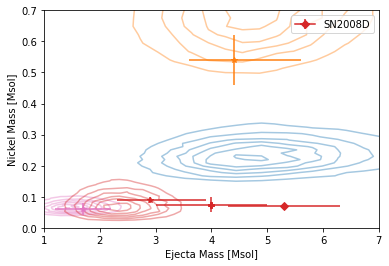

In [15]:
for ds_name in data.keys():
    print(ds_name)
    d = data[ds_name]
    print(len(d['Mej']))
    print(len(d['Mni']))
    mej = np.concatenate(d['Mej'])
    mni = np.concatenate(d['Mni'])
    #seaborn.kdeplot(mej, mni, label=ds_name, color=O2C[ds_name])
    H, ybins, xbins = np.histogram2d(mni, mej, bins=40)
    #print(H)
    #plt.hexbin(mni, mej)
    plt.contour(H,
                extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
                #linewidths=3,
                #vmin=10000000,
                #norm='log',
                locator=MaxNLocator(nbins=7, prune='lower'),
                label=ds_name,
                alpha=0.4,
                colors=O2C[ds_name])
### 2008D
# Tanaka (2009)
plt.errorbar([5.3], [0.07], yerr=0.07*0.1, xerr=1.0, label='SN2008D', color=O2C['SN2008D'], marker='D')

# Soderberg (2008)
plt.errorbar([4.0], [0.075], yerr=0.025, xerr=1.0, color=O2C['SN2008D'], marker='P')

# Lyman (2016)
plt.errorbar([2.9], [0.09], yerr=0.01, xerr=([0.6], [1.0]), color=O2C['SN2008D'], marker='*')
plt.errorbar([4.4], [0.54], yerr=0.08, xerr=([0.8], [1.2]), color=O2C['SN1998bw'], marker='*')
plt.errorbar([1.7], [0.06], yerr=0.02, xerr=0.5, color=O2C['iPTF13bvn'], marker='*')
    
plt.legend()
plt.xlabel('Ejecta Mass [Msol]')
plt.ylabel('Nickel Mass [Msol]')
plt.xlim((1, 7))
plt.ylim((0, 0.7))
plt.legend()
plt.savefig("../products/plots/2024-08-30-lc-param-mej-mni.png")

In [33]:
for ds_name in data.keys():
    d = data[ds_name]
    mej = np.concatenate(d['Mej'])
    mni = np.concatenate(d['Mni'])
    #seaborn.kdeplot(mej, mni, label=ds_name, color=O2C[ds_name])
    H, ybins, xbins = np.histogram2d(mni, mej, bins=50)
    plt.hist(H.flatten(), label=ds_name)

/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/welterde/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/

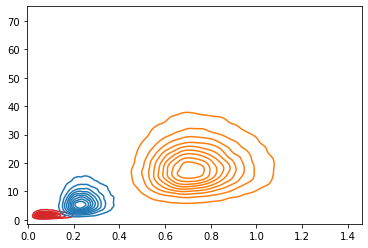

In [17]:
for ds_name in data.keys():
    d = data[ds_name]
    ek = np.concatenate(d['Ek'])
    mni = np.concatenate(d['Mni'])
    seaborn.kdeplot(mni, ek, label=ds_name, color=O2C[ds_name])

In [11]:
for ds_name in data.keys():
    d = data[ds_name]
    plt.hist(d['logz'], histtype='step', label=ds_name, color=O2C[ds_name])
plt.legend()

In [18]:
idx = 0
labels = ['Mni', 'Mej', 'v_sc', 'texpl', 'R_e', 'n', 't_diff']
k = list(results.keys())[idx]
tag = json.loads(k)
print(f"Loading {tag}")
r = results[k]
samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)

for i,l in enumerate(labels):
    print(f"{l} -> {mean[i]} \pm {cov[i,i]}")

dyplot.cornerplot(r.result, labels=labels, show_titles=True);

Loading ['SN2019odp_phot', 'piro2020_tdiff', [0, 30]]
Mni -> 0.22758279082095137 \pm 0.0002624742453530557
Mej -> 5.663112513804959 \pm 1.492178775902888
v_sc -> 14100.286737433218 \pm 262124.35402692686
texpl -> 58714.85605213687 \pm 0.901097758482259
R_e -> -0.02525035090028741 \pm 1.9287218935847619
n -> 13.227929621776399 \pm 16.50486713414032
t_diff -> 4.563543232957235 \pm 7.2283365753163915


Loading ['SN2019odp_phot', 'piro2020_me', [0, 10]]


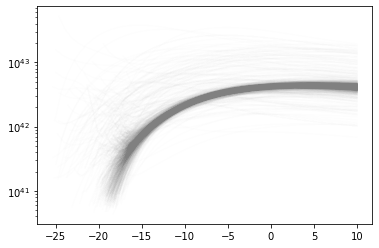

In [17]:
idx = 3
k = list(results.keys())[idx]
tag = json.loads(k)
print(f"Loading {tag}")
r = results[k]
samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)

lum_func = np.vectorize(shock_fit.luminosity_shock_arnett_tdiff)

peak_t = sn2019odp.load().transient.prior_t0

for i in range(1000):
    idx = np.random.randint(0, samples.shape[0])
    p = samples[idx]
    t_grid = np.linspace(p[3]+1, peak_t+10)
    lum = lum_func(t_grid, *p)
    plt.plot(t_grid - peak_t, np.exp(lum), alpha=0.01, color='grey')
plt.yscale('log')

In [10]:
def extract_p20_menv(tag, r):
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    assert tag.model in ['piro2020_tdiff', 'piro2020_me']
    t_diff = samples[:,6]
    vsc = samples[:,2]
    n = samples[:,5]
    
    K = (n-3)*(3-1.1)/4/np.pi/(n-1.1)
    opacity = 0.07 #cm^-2 g
    c_cgs = aconst.c.cgs.value
    return u.g.to(u.Msun) * (t_diff*u.d.to(u.s))**2 * (n-1) * (vsc*u.km.to(u.cm))*c_cgs/3/opacity/K

In [11]:
idx = 2
k = list(results.keys())[idx]
tag = json.loads(k)
rtag = Tag(*tag)
print(f"Loading {tag}")
r = results[k]
samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])

me = extract_p20_menv(rtag, r)
mej = samples[:,1]
#plt.hist(me);
#plt.scatter(mej, me, marker='.', s=0.1)
plt.hist(me/mej);

Loading ['SN2019odp_phot', 'piro2020_me', [0, 30]]


In [23]:
# show t_ph distribution
idx = 2
k = list(results.keys())[idx]
tag = json.loads(k)
rtag = Tag(*tag)
print(f"Loading {tag}")
r = results[k]
samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])

me = extract_p20_menv(rtag, r)
n = samples[:,5]
K = (n-3)*(3-1.1)/4/np.pi/(n-1.1)
vsc = samples[:,2]

opacity = 0.07
t_ph = np.sqrt(3*opacity*K*(me*u.Msun.to(u.g))/2/(n-1)/(vsc*u.km.to(u.cm))**2) * u.s.to(u.d)
plt.hist(t_ph);

Loading ['SN2019odp_phot', 'piro2020_me', [0, 30]]


Loading ['SN2019odp_phot', 'piro2020_me', [0, 30]]


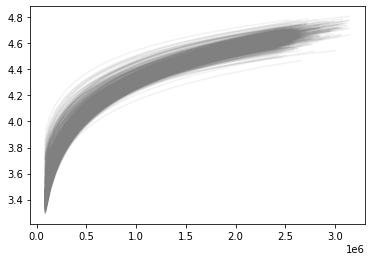

In [32]:
# draw sample r_ph lightcurves
# show t_ph distribution
idx = 2
k = list(results.keys())[idx]
tag = json.loads(k)
rtag = Tag(*tag)
print(f"Loading {tag}")
r = results[k]
samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])

me = extract_p20_menv(rtag, r)
n = samples[:,5]
K = (n-3)*(3-1.1)/4/np.pi/(n-1.1)
vsc = samples[:,2]

opacity = 0.07
t_ph = np.sqrt(3*opacity*K*(me*u.Msun.to(u.g))/2/(n-1)/(vsc*u.km.to(u.cm))**2) #* u.s.to(u.d)

for i in range(1000):
    idx = np.random.randint(0, samples.shape[0])
    p = samples[idx]
    t_grid = np.linspace(1, peak_t-p[3]+10) * u.d.to(u.s)
    
    r_ph = (t_ph[idx]/t_grid)**(2/(n[idx]-1)) * (vsc[idx]*u.km.to(u.cm)) * t_grid
    #r_ph = vsc[idx] * t_grid
    plt.plot(t_grid, np.log10(r_ph*u.cm.to(u.Rsun)), alpha=0.1, color='grey')
#plt.yscale('log')

In [29]:
r_ph

array([7.07560601e+13, 7.07567743e+13, 7.07574886e+13, 7.07582028e+13,
       7.07589171e+13, 7.07596313e+13, 7.07603456e+13, 7.07610598e+13,
       7.07617740e+13, 7.07624883e+13, 7.07632025e+13, 7.07639168e+13,
       7.07646310e+13, 7.07653453e+13, 7.07660595e+13, 7.07667737e+13,
       7.07674880e+13, 7.07682022e+13, 7.07689165e+13, 7.07696307e+13,
       7.07703450e+13, 7.07710592e+13, 7.07717734e+13, 7.07724877e+13,
       7.07732019e+13, 7.07739162e+13, 7.07746304e+13, 7.07753447e+13,
       7.07760589e+13, 7.07767731e+13, 7.07774874e+13, 7.07782016e+13,
       7.07789159e+13, 7.07796301e+13, 7.07803444e+13, 7.07810586e+13,
       7.07817728e+13, 7.07824871e+13, 7.07832013e+13, 7.07839156e+13,
       7.07846298e+13, 7.07853441e+13, 7.07860583e+13, 7.07867725e+13,
       7.07874868e+13, 7.07882010e+13, 7.07889153e+13, 7.07896295e+13,
       7.07903438e+13, 7.07910580e+13])

In [11]:
# extraction functions to get the mean & stddev values for each model run

def extract_mniV(tag, r):
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    mean, cov = dyfunc.mean_and_cov(samples, weights)
    trace = dyfunc.resample_equal(samples, weights)
    if tag.model in ['arnett', 'arnett_alt', 'arnett_r0']:
        return (mean[0], cov[0][0], trace[:,0])
    elif tag.model in ['tigerfit', 'tigerfit_e_th', 'tigerfit_trapped']:
        return (mean[0], cov[0][0], trace[:,0])
    else:
        return (np.nan, np.nan, np.array([]))
    
def extract_mejV(tag, r):
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    ds = get_ds(tag)
    
    if tag.model == 'arnett':
        td = trace[:,1] * u.day.to(u.s)
        opacity = 0.07
        beta = 13.8
        c=2.99792458e10
        v_sc = np.random.normal(ds.vsc_peak, ds.vsc_peak_err, size=len(td)) * u.km.to(u.cm)
        m_ej = td**2 * beta * c * v_sc / 2 / opacity * u.g.to(u.Msun)
        return np.nanmean(trace[:,1]), np.nanstd(trace[:,1]), np.nanmean(m_ej), np.nanstd(m_ej), m_ej
    elif tag.model == 'arnett_r0':
        td = trace[:,1] * u.day.to(u.s)
        opacity = 0.07
        beta = 13.8
        c=2.99792458e10
        v_sc = trace[:,5]
        m_ej = td**2 * beta * c * v_sc / 2 / opacity * u.g.to(u.Msun)
        return np.nanmean(trace[:,1]), np.nanstd(trace[:,1]), np.nanmean(m_ej), np.nanstd(m_ej), m_ej
    elif tag.model == 'arnett_alt':
        m_ej = trace[:,1]
        return np.nan, np.nan, np.nanmean(m_ej), np.nanstd(m_ej), m_ej
    elif tag.model in ['tigerfit', 'tigerfit_e_th', 'tigerfit_trapped']:
        td = trace[:,1] * u.day.to(u.s)
        opacity = 0.07
        beta = 13.8
        c=2.99792458e10
        #v_sc = np.random.normal(ds.vsc_peak, ds.vsc_peak_err, size=len(td)) * u.km.to(u.cm)
        v_sc = trace[:,3] * u.km.to(u.cm)
        m_ej = td**2 * beta * c * v_sc / 2 / opacity * u.g.to(u.Msun)
        return np.nanmean(trace[:,1]), np.nanstd(trace[:,1]), np.nanmean(m_ej), np.nanstd(m_ej), m_ej
    else:
        return (np.nan, np.nan, np.nan, np.nan, np.array([]))

def extract_ekinV(tag, r):
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    ds = get_ds(tag)
    
    if tag.model == 'arnett_alt':
        m_ej = trace[:,1] # [Msol]
        v_sc = trace[:,2] # [km/s]
        # we need * v_m^2 -> * \xi^2 -> * 0.6 = 3/5
        e_kin = m_ej * u.Msun.to(u.g) / 2 * (v_sc * u.km.to(u.cm))**2 * 0.6 / 1e51 # [foe]
    elif tag.model == 'arnett_r0':
        td = trace[:,1] * u.day.to(u.s)
        opacity = 0.07
        beta = 13.8
        c=2.99792458e10
        
        v_sc = trace[:,5] # [cm/s]
        # we need * v_m^2 -> * \xi^2 -> * 0.6 = 3/5
        e_kin = td**2 * beta * c * v_sc**3 * 0.6 / 4 / opacity / 1e51 # [foe]
    elif tag.model == 'arnett':
        td = trace[:,1] * u.day.to(u.s)
        opacity = 0.07
        beta = 13.8
        c=2.99792458e10
        v_sc = np.random.normal(ds.vsc_peak, ds.vsc_peak_err, size=len(td)) * u.km.to(u.cm)
        # we need * v_m^2 -> * \xi^2 -> * 0.6 = 3/5
        e_kin = td**2 * beta * c * v_sc**3 * 0.6 / 4 / opacity / 1e51 # [foe]
    else:
        print('* Warning: Unknown model %s' % tag.model)
        e_kin = np.nan * trace[:,0]
    return np.nanmean(e_kin), np.nanstd(e_kin), e_kin
    
def extract_r0V(tag, r):
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    ds = get_ds(tag)
    
    if tag.model in ['tigerfit', 'tigerfit_e_th', 'tigerfit_trapped']:
        r0 = trace[:,2] * 1e15 * u.cm.to(u.Rsun)
        rn,rp = np.quantile(r0, [0.16, 0.84])
        mean = np.nanmean(r0)
        return mean, np.nanstd(r0), (mean-rn), (rp-mean)
    elif tag.model == 'arnett_r0':
        r0 = trace[:,3] * u.cm.to(u.Rsun)
        rn,rp = np.quantile(r0, [0.16, 0.84])
        mean = np.nanmean(r0)
        return mean, np.nanstd(r0), (mean-rn), (rp-mean)
    else:
        return np.nan, np.nan, np.nan, np.nan

In [12]:
# extract the data in summarized form
d = {'tag': [], 'logz': [], 'model': [], 'tmin': [], 'tmax': [], 'duration': [], 'dataset': [], 'Mni': [], 'Mni_err': [], 'Mni_err_neg': [], 'Mni_err_pos': [], 'Mej': [], 'Mej_err': [], 'Mej_err_neg': [], 'Mej_err_pos': [], 'Ek': [], 'Ek_err': [], 'R0': [], 'R0_err': [], 'R0_err_n': [], 'R0_err_p': [], 't_d': [], 't_d_err': []}
for k in results.keys():
    # decode the tag
    tag = json.loads(k)
    rtag = Tag(*tag)
    
    # the Piro2021 models here are not really relevant
    if rtag.model in ['piro2020_me', 'piro2020_tdiff']:
        continue
    ds = get_ds(rtag)
    v = results[k]
    d['tag'].append(k)
    d['logz'].append(v.logz)
    #d['tmin'].append(tag[2][0])
    d['tmax'].append(tag[2][1])
    time_range = (float(rtag.params[0] + ds.time_valid[0][0]), float(rtag.params[1]+ds.load().transient.prior_t0))
    d['tmin'].append(rtag.params[0] + ds.time_valid[0][0] - ds.load().transient.prior_t0)
    d['duration'].append(time_range[1] - time_range[0])
    d['dataset'].append(tag[0])
    d['model'].append(tag[1])
    mni, mni_err, mni_trace = extract_mniV(rtag, v)
    d['Mni'].append(mni)
    d['Mni_err'].append(mni_err)
    mni_perc = np.percentile(mni_trace, [15.9, 50, 84.1])
    d['Mni_err_neg'].append(mni_perc[1]-mni_perc[0])
    d['Mni_err_pos'].append(mni_perc[2]-mni_perc[1])
    
    ek, ek_err, _ = extract_ekinV(rtag, v)
    d['Ek'].append(ek)
    d['Ek_err'].append(ek_err)
    
    td, td_err, mej, mej_err, mej_trace = extract_mejV(rtag, v)
    d['Mej'].append(mej)
    d['Mej_err'].append(mej_err)
    mej_perc = np.percentile(mej_trace, [15.9, 50, 84.1])
    d['Mej_err_neg'].append(mej_perc[1]-mej_perc[0])
    d['Mej_err_pos'].append(mej_perc[2]-mej_perc[1])
    
    d['t_d'].append(td)
    d['t_d_err'].append(td_err)
    r0, r0_err, r0_en, r0_ep = extract_r0V(rtag, v)
    d['R0'].append(r0)
    d['R0_err'].append(r0_err)
    d['R0_err_n'].append(r0_en)
    d['R0_err_p'].append(r0_ep)
    
#import pandas as pd
df = pd.DataFrame(data=d)
df

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the f

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the f

* Warning: Unknown model tigerfit


<ipython-input-11-13f3c1128091>:80: RuntimeWarning: Mean of empty slice
  return np.nanmean(e_kin), np.nanstd(e_kin), e_kin
/home/welterde/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this 

* Warning: Unknown model tigerfit


<ipython-input-11-13f3c1128091>:80: RuntimeWarning: Mean of empty slice
  return np.nanmean(e_kin), np.nanstd(e_kin), e_kin
/home/welterde/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this 

* Warning: Unknown model tigerfit


<ipython-input-11-13f3c1128091>:80: RuntimeWarning: Mean of empty slice
  return np.nanmean(e_kin), np.nanstd(e_kin), e_kin
/home/welterde/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this 

* Warning: Unknown model tigerfit


<ipython-input-11-13f3c1128091>:80: RuntimeWarning: Mean of empty slice
  return np.nanmean(e_kin), np.nanstd(e_kin), e_kin
/home/welterde/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this 

* Warning: Unknown model tigerfit


<ipython-input-11-13f3c1128091>:80: RuntimeWarning: Mean of empty slice
  return np.nanmean(e_kin), np.nanstd(e_kin), e_kin
/home/welterde/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this 

* Warning: Unknown model tigerfit


<ipython-input-11-13f3c1128091>:80: RuntimeWarning: Mean of empty slice
  return np.nanmean(e_kin), np.nanstd(e_kin), e_kin
/home/welterde/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this 

* Warning: Unknown model tigerfit


<ipython-input-11-13f3c1128091>:80: RuntimeWarning: Mean of empty slice
  return np.nanmean(e_kin), np.nanstd(e_kin), e_kin
/home/welterde/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


tag       logz       model  \
0          ["iPTF13bvn", "arnett_r0", [6, 25]] -15.125831   arnett_r0   
1             ["iPTF13bvn", "arnett", [6, 25]] -12.903853      arnett   
2           ["SN1998bw", "arnett_r0", [6, 25]]  -8.817704   arnett_r0   
3              ["SN1998bw", "arnett", [6, 25]]  -6.769951      arnett   
4            ["SN2008D", "arnett_r0", [6, 25]] -10.567506   arnett_r0   
5               ["SN2008D", "arnett", [6, 25]]  -8.363561      arnett   
6     ["SN2019odp_phot", "arnett_r0", [6, 25]]  -8.758412   arnett_r0   
7        ["SN2019odp_phot", "arnett", [6, 25]]  -6.684262      arnett   
8          ["iPTF13bvn", "arnett_r0", [4, 25]] -14.977790   arnett_r0   
9             ["iPTF13bvn", "arnett", [4, 25]] -12.947214      arnett   
10          ["SN1998bw", "arnett_r0", [4, 25]]  -8.892582   arnett_r0   
11             ["SN1998bw", "arnett", [4, 25]]  -6.734940      arnett   
12           ["SN2008D", "arnett_r0", [4, 25]] -10.911468   arnett_r0   
13              ["SN2008D", "arnett", [4, 25]]  -8.570095      arnett   
14    ["SN2019odp_phot", "arnett_r0", [4, 25]]  -9.098442   arnett_r0   
15       ["SN2019odp_phot", "arnett", [4, 25]]  -6.880863      arnett   
16         ["iPTF13bvn", "arnett_r0", [6, 30]] -17.177936   arnett_r0   
17           ["SN2008D", "arnett_r0", [8, 30]] -11.795863   arnett_r0   
18              ["SN2008D", "arnett", [8, 30]]  -9.534864      arnett   
19          ["SN1998bw", "arnett_r0", [8, 30]] -10.131309   arnett_r0   
20             ["SN1998bw", "arnett", [8, 30]]  -8.048769      arnett   
21    ["SN2019odp_phot", "arnett_r0", [8, 30]]  -8.923603   arnett_r0   
22       ["SN2019odp_phot", "arnett", [8, 30]]  -6.796292      arnett   
23         ["iPTF13bvn", "arnett_r0", [8, 30]] -17.433212   arnett_r0   
24            ["iPTF13bvn", "arnett", [8, 30]] -15.057158      arnett   
25        ["iPTF13bvn", "arnett_alt", [8, 30]] -14.754845  arnett_alt   
26          ["iPTF13bvn", "tigerfit", [8, 30]] -14.699948    tigerfit   
27   ["SN2019odp_phot", "arnett_alt", [8, 30]]  -5.689143  arnett_alt   
28     ["SN2019odp_phot", "tigerfit", [8, 30]]  -6.789109    tigerfit   
29         ["SN1998bw", "arnett_alt", [8, 30]]  -6.799138  arnett_alt   
30           ["SN1998bw", "tigerfit", [8, 30]]  -7.968958    tigerfit   
31          ["SN2008D", "arnett_alt", [8, 30]]  -9.096982  arnett_alt   
32            ["SN2008D", "tigerfit", [8, 30]]  -9.641625    tigerfit   
33           ["iPTF13bvn", "arnett", [10, 30]] -15.236801      arnett   
34        ["iPTF13bvn", "arnett_r0", [10, 30]] -17.839962   arnett_r0   
35       ["iPTF13bvn", "arnett_alt", [10, 30]] -14.975478  arnett_alt   
36         ["iPTF13bvn", "tigerfit", [10, 30]] -14.668004    tigerfit   
37      ["SN2019odp_phot", "arnett", [10, 30]]  -6.532757      arnett   
38   ["SN2019odp_phot", "arnett_r0", [10, 30]]  -8.613444   arnett_r0   
39  ["SN2019odp_phot", "arnett_alt", [10, 30]]  -5.452026  arnett_alt   
40    ["SN2019odp_phot", "tigerfit", [10, 30]]  -6.718462    tigerfit   
41            ["SN1998bw", "arnett", [10, 30]]  -8.113597      arnett   
42         ["SN1998bw", "arnett_r0", [10, 30]] -10.301426   arnett_r0   
43        ["SN1998bw", "arnett_alt", [10, 30]]  -6.805540  arnett_alt   
44             ["SN2008D", "arnett", [10, 30]]  -9.488296      arnett   
45          ["SN2008D", "arnett_r0", [10, 30]] -11.709336   arnett_r0   
46         ["SN2008D", "arnett_alt", [10, 30]]  -8.997537  arnett_alt   
47           ["SN2008D", "tigerfit", [10, 30]]  -9.370648    tigerfit   

         tmin  tmax   duration         dataset       Mni   Mni_err  \
0  -10.617000    25  35.617000       iPTF13bvn  0.071860  0.000260   
1  -10.617000    25  35.617000       iPTF13bvn  0.072436  0.000298   
2   -8.369995    25  33.369995        SN1998bw  0.747993  0.015871   
3   -8.369995    25  33.369995        SN1998bw  0.753033  0.016037   
4  -11.586650    25  36.586650         SN2008D  0.086525  0.001089   
5  -11.586650    25  36.586650         SN2008

In [35]:
df.query('dataset == "SN1998bw"')

tag      logz       model       tmin  \
19  ["SN1998bw", "arnett_alt", [6, 25]] -5.400849  arnett_alt  -8.369995   
20      ["SN1998bw", "arnett", [4, 20]] -5.976182      arnett -10.369995   
25      ["SN1998bw", "arnett", [8, 10]] -4.994715      arnett  -6.369995   
26  ["SN1998bw", "arnett_alt", [8, 10]] -3.462355  arnett_alt  -6.369995   
28   ["SN1998bw", "arnett_r0", [4, 25]] -8.846240   arnett_r0 -10.369995   

    tmax   duration   dataset       Mni   Mni_err  Mni_err_neg  Mni_err_pos  \
19    25  33.369995  SN1998bw  0.751857  0.016088     0.115574     0.139275   
20    20  30.369995  SN1998bw  0.783452  0.017125     0.120599     0.136385   
25    10  16.369995  SN1998bw  0.860288  0.027535     0.144466     0.183633   
26    10  16.369995  SN1998bw  0.857015  0.024548     0.140335     0.173705   
28    25  35.369995  SN1998bw  0.748398  0.014449     0.114823     0.119993   

         Mej   Mej_err  Mej_err_neg  Mej_err_pos            Ek        Ek_err  \
19  5.261041  0.999605     0.955965     1.025894  1.991016e+01  4.050851e+00   
20  5.692788  1.074249     0.968027     1.112727  2.198249e+01  6.839950e+00   
25  6.652536  1.878201     1.426995     2.003538  2.574637e+01  9.822123e+00   
26  6.614657  1.424951     1.436369     1.606572  2.508102e+01  5.641791e+00   
28  0.000053  0.000009     0.000008     0.000009  2.013261e-14  3.634717e-15   

          R0    R0_err  R0_err_n  R0_err_p        t_d   t_d_err  
19       NaN       NaN       NaN       NaN        NaN       NaN  
20       NaN       NaN       NaN       NaN  14.227565  1.177437  
25       NaN       NaN       NaN       NaN  15.309630  1.989960  
26       NaN       NaN       NaN       NaN        NaN       NaN  
28  0.001229  0.001543  0.001125  0.001485  13.742403  1.131908

In [13]:
df.query('dataset == "SN2008D"')

tag       logz       model      tmin  \
4     ["SN2008D", "arnett_r0", [6, 25]] -10.567506   arnett_r0 -11.58665   
5        ["SN2008D", "arnett", [6, 25]]  -8.363561      arnett -11.58665   
12    ["SN2008D", "arnett_r0", [4, 25]] -10.911468   arnett_r0 -13.58665   
13       ["SN2008D", "arnett", [4, 25]]  -8.570095      arnett -13.58665   
17    ["SN2008D", "arnett_r0", [8, 30]] -11.795863   arnett_r0  -9.58665   
18       ["SN2008D", "arnett", [8, 30]]  -9.534864      arnett  -9.58665   
31   ["SN2008D", "arnett_alt", [8, 30]]  -9.096982  arnett_alt  -9.58665   
32     ["SN2008D", "tigerfit", [8, 30]]  -9.641625    tigerfit  -9.58665   
44      ["SN2008D", "arnett", [10, 30]]  -9.488296      arnett  -7.58665   
45   ["SN2008D", "arnett_r0", [10, 30]] -11.709336   arnett_r0  -7.58665   
46  ["SN2008D", "arnett_alt", [10, 30]]  -8.997537  arnett_alt  -7.58665   
47    ["SN2008D", "tigerfit", [10, 30]]  -9.370648    tigerfit  -7.58665   

    tmax  duration  dataset       Mni   Mni_err  Mni_err_neg  Mni_err_pos  \
4     25  36.58665  SN2008D  0.086525  0.001089     0.027012     0.037165   
5     25  36.58665  SN2008D  0.088640  0.001353     0.028401     0.041834   
12    25  38.58665  SN2008D  0.085327  0.000959     0.026650     0.034791   
13    25  38.58665  SN2008D  0.088713  0.001325     0.028845     0.042138   
17    30  39.58665  SN2008D  0.082712  0.000984     0.026310     0.035221   
18    30  39.58665  SN2008D  0.085854  0.001248     0.027742     0.041939   
31    30  39.58665  SN2008D  0.083910  0.001147     0.026574     0.040311   
32    30  39.58665  SN2008D  0.083642  0.000929     0.026166     0.035937   
44    30  37.58665  SN2008D  0.087793  0.001409     0.028031     0.043534   
45    30  37.58665  SN2008D  0.082366  0.000990     0.026692     0.036129   
46    30  37.58665  SN2008D  0.082714  0.001040     0.026062     0.037679   
47    30  37.58665  SN2008D  0.085415  0.000963     0.026402     0.036181   

         Mej   Mej_err  Mej_err_neg  Mej_err_pos            Ek        Ek_err  \
4   0.000025  0.000004     0.000004     0.000004  1.604847e-15  3.193259e-16   
5   2.521664  0.542598     0.491606     0.569588  1.680939e+00  6.934206e-01   
12  0.000024  0.000004     0.000004     0.000004  1.523803e-15  2.962791e-16   
13  2.395775  0.496709     0.447012     0.525064  1.600892e+00  6.534034e-01   
17  0.000024  0.000005     0.000004     0.000005  1.535685e-15  3.377539e-16   
18  2.402513  0.578262     0.523172     0.608300  1.594465e+00  6.879708e-01   
31  2.466067  0.493333     0.464598     0.511167  1.575145e+00  3.499747e-01   
32  2.454812  0.482035     0.452618     0.472349           NaN           NaN   
44  2.327716  0.650593     0.592501     0.664505  1.549014e+00  7.014315e-01   
45  0.000024  0.000005     0.000005     0.000005  1.513341e-15  3.631131e-16   
46  2.397816  0.563261     0.538191     0.564501  1.535950e+00  3.902496e-01   
47  2.392345  0.569543     0.539647     0.553643           NaN           NaN   

          R0     R0_err  R0_err_n  R0_err_p        t_d   t_d_err  
4   0.001263   0.001576  0.001156  0.001529  14.751110  1.251298  
5        NaN        NaN       NaN       NaN  14.765932  1.292159  
12  0.001254   0.001548  0.001145  0.001492  14.386691  1.180489  
13       NaN        NaN       NaN       NaN  14.420268  1.191998  
17  0.001282   0.001561  0.001171  0.001628  14.428412  1.404847  
18       NaN        NaN       NaN       NaN  14.403450  1.488769  
31       NaN        NaN       NaN       NaN        NaN       NaN  
32  8.125198  17.289243  8.104457  6.916794  14.575344  1.426226  
44       NaN        NaN       NaN       NaN  14.141672  1.843361  
45  0.001278   0.001553  0.001170  0.001544  14.303928  1.558251  
46       NaN        NaN       NaN       NaN        NaN       NaN  
47  8.614431  18.123530  8.589089  7.650766  14.350922  1.748042

In [36]:
df.query('dataset == "SN2019odp_phot" and model == "arnett"')

tag      logz   model       tmin  tmax  \
1   ["SN2019odp_phot", "arnett", [6, 30]] -6.866713  arnett -10.605104    30   
21  ["SN2019odp_phot", "arnett", [8, 10]] -5.624672  arnett  -8.605104    10   

     duration         dataset       Mni   Mni_err  Mni_err_neg  Mni_err_pos  \
1   40.605104  SN2019odp_phot  0.237659  0.002101     0.042509     0.049288   
21  18.605104  SN2019odp_phot  0.307362  0.011138     0.063730     0.093505   

         Mej   Mej_err  Mej_err_neg  Mej_err_pos         Ek    Ek_err  R0  \
1   5.242579  1.313686     1.125735     1.436997   6.499118  2.896587 NaN   
21  8.186653  4.442876     2.157909     3.717931  10.125249  6.729692 NaN   

    R0_err  R0_err_n  R0_err_p        t_d   t_d_err  
1      NaN       NaN       NaN  18.214022  1.907982  
21     NaN       NaN       NaN  22.337876  4.940025

In [37]:
df.iloc[df.query('tmax > 15').groupby(['dataset', 'model'])['logz'].idxmax()]

tag       logz       model  \
20            ["SN1998bw", "arnett", [4, 20]]  -5.976182      arnett   
19        ["SN1998bw", "arnett_alt", [6, 25]]  -5.400849  arnett_alt   
28         ["SN1998bw", "arnett_r0", [4, 25]]  -8.846240   arnett_r0   
1       ["SN2019odp_phot", "arnett", [6, 30]]  -6.866713      arnett   
18  ["SN2019odp_phot", "arnett_alt", [6, 20]]  -5.480339  arnett_alt   
29   ["SN2019odp_phot", "arnett_r0", [4, 25]]  -9.100709   arnett_r0   
15       ["iPTF13bvn", "arnett_alt", [4, 20]] -10.415219  arnett_alt   
27        ["iPTF13bvn", "arnett_r0", [4, 25]] -15.128519   arnett_r0   

         tmin  tmax   duration         dataset       Mni   Mni_err  \
20 -10.369995    20  30.369995        SN1998bw  0.783452  0.017125   
19  -8.369995    25  33.369995        SN1998bw  0.751857  0.016088   
28 -10.369995    25  35.369995        SN1998bw  0.748398  0.014449   
1  -10.605104    30  40.605104  SN2019odp_phot  0.237659  0.002101   
18 -10.605104    20  30.605104  SN2019odp_phot  0.254154  0.002603   
29 -12.605104    25  37.605104  SN2019odp_phot  0.244729  0.002078   
15 -12.617000    20  32.617000       iPTF13bvn  0.076122  0.000312   
27 -12.617000    25  37.617000       iPTF13bvn  0.071186  0.000256   

    Mni_err_neg  Mni_err_pos       Mej   Mej_err  Mej_err_neg  Mej_err_pos  \
20     0.120599     0.136385  5.692788  1.074249     0.968027     1.112727   
19     0.115574     0.139275  5.261041  0.999605     0.955965     1.025894   
28     0.114823     0.119993  0.000053  0.000009     0.000008     0.000009   
1      0.042509     0.049288  5.242579  1.313686     1.125735     1.436997   
18     0.046323     0.053946  6.006374  1.329438     1.196775     1.526425   
29     0.042568     0.047379  0.000056  0.000012     0.000011     0.000014   
15     0.015588     0.020152  1.947307  0.351315     0.325061     0.367457   
27     0.014616     0.017292  0.000018  0.000003     0.000003     0.000003   

              Ek        Ek_err        R0    R0_err  R0_err_n  R0_err_p  \
20  2.198249e+01  6.839950e+00       NaN       NaN       NaN       NaN   
19  1.991016e+01  4.050851e+00       NaN       NaN       NaN       NaN   
28  2.013261e-14  3.634717e-15  0.001229  0.001543  0.001125  0.001485   
1   6.499118e+00  2.896587e+00       NaN       NaN       NaN       NaN   
18  7.158526e+00  1.753402e+00       NaN       NaN       NaN       NaN   
29  6.690037e-15  1.619637e-15  0.001226  0.001523  0.001115  0.001462   
15  1.248107e+00  2.582996e-01       NaN       NaN       NaN       NaN   
27  1.132375e-15  2.294248e-16  0.001279  0.001568  0.001166  0.001506   

          t_d   t_d_err  
20  14.227565  1.177437  
19        NaN       NaN  
28  13.742403  1.131908  
1   18.214022  1.907982  
18        NaN       NaN  
29  18.889719  2.034979  
15        NaN       NaN  
27  12.380996  1.068853

In [38]:
df.iloc[df.groupby(['dataset', 'model', 'tmin', 'tmax'])['logz'].idxmax()]

tag       logz       model  \
20            ["SN1998bw", "arnett", [4, 20]]  -5.976182      arnett   
25            ["SN1998bw", "arnett", [8, 10]]  -4.994715      arnett   
19        ["SN1998bw", "arnett_alt", [6, 25]]  -5.400849  arnett_alt   
26        ["SN1998bw", "arnett_alt", [8, 10]]  -3.462355  arnett_alt   
28         ["SN1998bw", "arnett_r0", [4, 25]]  -8.846240   arnett_r0   
1       ["SN2019odp_phot", "arnett", [6, 30]]  -6.866713      arnett   
21      ["SN2019odp_phot", "arnett", [8, 10]]  -5.624672      arnett   
14  ["SN2019odp_phot", "arnett_alt", [2, 20]]  -5.995193  arnett_alt   
4   ["SN2019odp_phot", "arnett_alt", [2, 25]]  -6.045588  arnett_alt   
10  ["SN2019odp_phot", "arnett_alt", [2, 30]]  -6.314376  arnett_alt   
16  ["SN2019odp_phot", "arnett_alt", [4, 20]]  -5.794400  arnett_alt   
6   ["SN2019odp_phot", "arnett_alt", [4, 25]]  -5.733922  arnett_alt   
12  ["SN2019odp_phot", "arnett_alt", [4, 30]]  -6.125697  arnett_alt   
18  ["SN2019odp_phot", "arnett_alt", [6, 20]]  -5.480339  arnett_alt   
8   ["SN2019odp_phot", "arnett_alt", [6, 25]]  -5.656537  arnett_alt   
0   ["SN2019odp_phot", "arnett_alt", [6, 30]]  -5.859439  arnett_alt   
22  ["SN2019odp_phot", "arnett_alt", [8, 10]]  -4.633587  arnett_alt   
29   ["SN2019odp_phot", "arnett_r0", [4, 25]]  -9.100709   arnett_r0   
23           ["iPTF13bvn", "arnett", [8, 10]]  -7.707953      arnett   
13       ["iPTF13bvn", "arnett_alt", [2, 20]] -10.600369  arnett_alt   
3        ["iPTF13bvn", "arnett_alt", [2, 25]] -12.319349  arnett_alt   
9        ["iPTF13bvn", "arnett_alt", [2, 30]] -14.180148  arnett_alt   
15       ["iPTF13bvn", "arnett_alt", [4, 20]] -10.415219  arnett_alt   
5        ["iPTF13bvn", "arnett_alt", [4, 25]] -12.524474  arnett_alt   
11       ["iPTF13bvn", "arnett_alt", [4, 30]] -14.368524  arnett_alt   
17       ["iPTF13bvn", "arnett_alt", [6, 20]] -10.481060  arnett_alt   
7        ["iPTF13bvn", "arnett_alt", [6, 25]] -12.658122  arnett_alt   
2        ["iPTF13bvn", "arnett_alt", [6, 30]] -14.579292  arnett_alt   
24       ["iPTF13bvn", "arnett_alt", [8, 10]]  -7.147515  arnett_alt   
27        ["iPTF13bvn", "arnett_r0", [4, 25]] -15.128519   arnett_r0   

         tmin  tmax   duration         dataset       Mni   Mni_err  \
20 -10.369995    20  30.369995        SN1998bw  0.783452  0.017125   
25  -6.369995    10  16.369995        SN1998bw  0.860288  0.027535   
19  -8.369995    25  33.369995        SN1998bw  0.751857  0.016088   
26  -6.369995    10  16.369995        SN1998bw  0.857015  0.024548   
28 -10.369995    25  35.369995        SN1998bw  0.748398  0.014449   
1  -10.605104    30  40.605104  SN2019odp_phot  0.237659  0.002101   
21  -8.605104    10  18.605104  SN2019odp_phot  0.307362  0.011138   
14 -14.605104    20  34.605104  SN2019odp_phot  0.253198  0.002710   
4  -14.605104    25  39.605104  SN2019odp_phot  0.245441  0.002394   
10 -14.605104    30  44.605104  SN2019odp_phot  0.238494  0.002194   
16 -12.605104    20  32.605104  SN2019odp_phot  0.253750  0.002634   
6  -12.605104    25  37.605104  SN2019odp_phot  0.246551  0.002363   
12 -12.605104    30  42.605104  SN2019odp_phot  0.239433  0.002225   
18 -10.605104    20  30.605104  SN2019odp_phot  0.254154  0.002603   
8  -10.605104    25  35.605104  SN2019odp_phot  0.246232  0.002380   
0  -10.605104    30  40.605104  SN2019odp_phot  0.240527  0.002312   
22  -8.605104    10  18.605104  SN2019odp_phot  0.282076  0.004194   
29 -12.605104    25  37.605104  SN2019odp_phot  0.244729  0.002078   
23  -8.617000    10  18.617000       iPTF13bvn  0.087186  0.000422   
13 -14.617000    20  34.617000       iPTF13bvn  0.076416  0.000302   
3  -14.617000    25  39.617000       iPTF13bvn  0.072402  0.000273   
9  -14.617000    30  44.617000       iPTF13bvn  0.068059  0.000251   
15 -12.617000    20  32.617000       iPTF13bvn  0.076122  0.000312   
5  -12.617000    25  37.617000       iPTF13bvn  0.071545  0.000249   
11 -12.617000    30  42.617000       iPTF13bvn  0.067391  0

In [21]:
plt.figure(figsize=(11,11))
df.query('dataset == "SN2019odp_phot" and model == "arnett_alt"').set_index('tmax').sort_index().groupby(['model', 'tmin'])['Mej'].plot(legend=True);

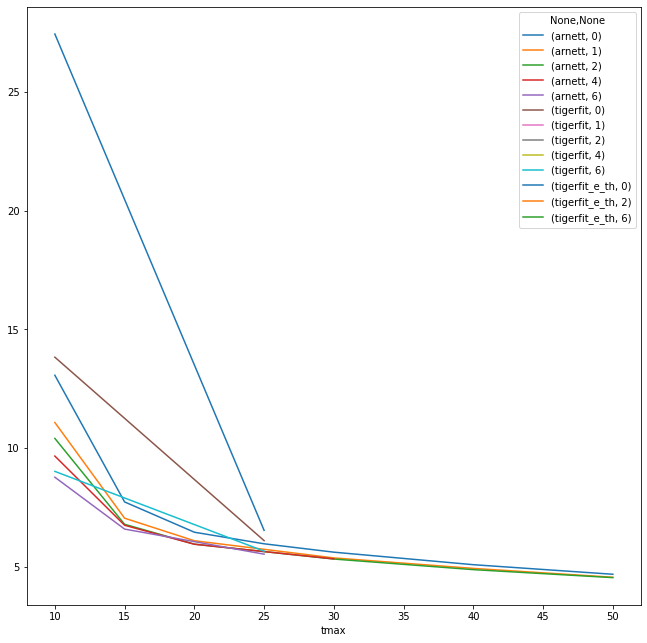

In [84]:
plt.figure(figsize=(11,11))
df.query('dataset == "SN2019odp_phot"').set_index('tmax').sort_index().groupby(['model', 'tmin'])['Mej'].plot(legend=True);

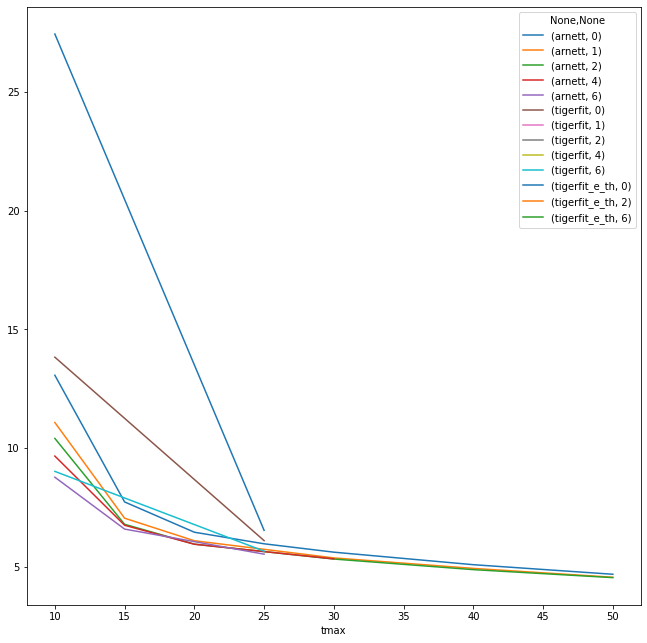

In [76]:
plt.figure(figsize=(11,11))
df.query('dataset == "SN2019odp_phot"').set_index('tmax').sort_index().groupby(['model', 'tmin'])['Mej'].plot(legend=True);

In [77]:
# attempt model averaging
samples_m, weights_m = [], []
for tag in df.query('dataset == "SN2019odp_phot" and model == "arnett"')['tag']:
    tag = json.loads(tag)
    rtag = Tag(*tag)
    r = results[k]
    samples, weights = r.sampler.results.samples, np.exp(r.sampler.results.logwt - r.sampler.results.logz[-1])
    trace = dyfunc.resample_equal(samples, weights)
    samples_m.append(trace)
    weights_m.append(np.ones(len(trace))*np.exp(r.sampler.results.logz[-1]))

In [78]:
samples = np.concatenate(samples_m)
weights = np.concatenate(weights_m)
trace = dyfunc.resample_equal(samples, weights)


/home/welterde/.local/lib/python3.8/site-packages/dynesty/utils.py:163: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


In [79]:
plt.hist(trace[:,1], bins=100)
print(np.nanmean(trace[:,1]), np.nanstd(trace[:,1]))

13.820496113839328 1.6037335220324453


In [80]:
plt.hist(trace[:,0], bins=100);
print(np.nanmean(trace[:,0]), np.nanstd(trace[:,0]))

0.08177090205238487 0.023063759962569694


In [81]:
td = trace[:,1] * u.day.to(u.s)
opacity = 0.07
beta = 13.8
c=2.99792458e10
v_sc = sn2019odp.vsc_peak * u.km.to(u.cm)
m_ej = td**2 * beta * c * v_sc / 2 / opacity * u.g.to(u.Msun)
print(np.mean(m_ej), np.std(m_ej))
plt.hist(m_ej, bins=100);

3.025368111812644 0.7116823390239713


In [82]:
sn2019odp.vsc_peak

14087.33142460511

In [66]:
# delete the tigerfit ones
for k in results:
    if 'tigerfit' in k:
        print(k)
        #del results[k]

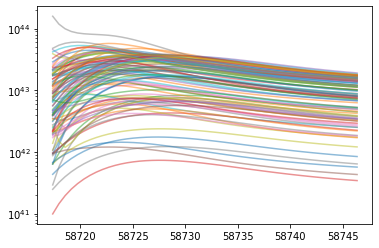

In [7]:
ds = sn2019odp
vsc_min, vsc_max = (ds.vsc_peak - ds.vsc_peak_err/2, ds.vsc_peak + ds.vsc_peak_err/2)
texpl_min, texpl_max = ds.texpl_range

for i in range(100):
    p = shock_fit.prior_shock_arnett_tdiff(np.random.uniform(0, 1, size=7), vsc_min, vsc_max, texpl_min, texpl_max, 0.1, 100, 0.5, 10)
    lum = np.vectorize(shock_fit.luminosity_shock_arnett_tdiff)
    t_grid = np.linspace(sn2019odp.texpl_max+1, sn2019odp.texpl_max+30)
    lums = lum(t_grid, *p)
    plt.plot(t_grid, np.exp(lums), alpha=0.5)
plt.yscale('log')

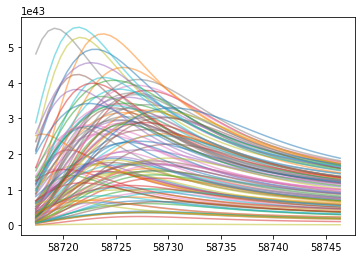

In [21]:
ds = sn2019odp
vsc_min, vsc_max = (ds.vsc_peak - ds.vsc_peak_err/2, ds.vsc_peak + ds.vsc_peak_err/2)
texpl_min, texpl_max = ds.texpl_range

for i in range(100):
    p = arnett.prior_nico_alt(np.random.uniform(0, 1, size=4), vsc_min, vsc_max, texpl_min, texpl_max)
    lum = np.vectorize(arnett.luminosity_nico_alt)
    t_grid = np.linspace(sn2019odp.texpl_max+1, sn2019odp.texpl_max+30)
    lums = lum(t_grid, *p)
    plt.plot(t_grid, np.exp(lums), alpha=0.5)
#plt.yscale('log')

In [43]:
def quantiles2(t):
    q = np.percentile(t, [15.6, 50, 84.1])
    err_neg = q[1] - q[0]
    err_pos = q[2] - q[1]
    return "%.2f_{-%.2f}^{+%.2f}" % (q[1], err_neg, err_pos)

# extract the data
d = {'tag': [], 'logz': [], 'model': [], 'tmin': [], 'tmax': [], 'duration': [], 'dataset': [], 'Mni': [],  'Mej': [], 'Ek': []}
for k in results.keys():
    tag = json.loads(k)
    rtag = Tag(*tag)
    # the Piro2021 models here are not really relevant
    if rtag.model in ['piro2020_me', 'piro2020_tdiff']:
        continue
    ds = get_ds(rtag)
    v = results[k]
    d['tag'].append(k)
    d['logz'].append(v.logz)
    #d['tmin'].append(tag[2][0])
    d['tmax'].append(tag[2][1])
    time_range = (float(rtag.params[0] + ds.time_valid[0][0]), float(rtag.params[1]+ds.load().transient.prior_t0))
    d['tmin'].append(rtag.params[0] + ds.time_valid[0][0] - ds.load().transient.prior_t0)
    d['duration'].append(time_range[1] - time_range[0])
    d['dataset'].append(tag[0])
    d['model'].append(tag[1])
    _mni, _mni_err, mni = extract_mni(rtag, v)
    mni = quantiles2(mni)
    d['Mni'].append(mni)
    
    
    _ek, _ek_err, ek = extract_ekin(rtag, v)
    ek = quantiles2(ek)
    d['Ek'].append(ek)
    
    
    _td, _td_err, _mej, _mej_err, mej = extract_mej(rtag, v)
    mej = quantiles2(mej)
    d['Mej'].append(mej)
    
    
import pandas as pd
df_str = pd.DataFrame(data=d)
df_str

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the f

/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  return self.as_void() == other
/home/welterde/.local/lib/python3.8/site-packages/astropy/table/row.py:76: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the f

tag       logz       model  \
0   ["SN2019odp_phot", "arnett_alt", [6, 30]]  -5.959892  arnett_alt   
1       ["SN2019odp_phot", "arnett", [6, 30]]  -6.866713      arnett   
2        ["iPTF13bvn", "arnett_alt", [6, 30]] -14.579292  arnett_alt   
3        ["iPTF13bvn", "arnett_alt", [2, 25]] -12.319349  arnett_alt   
4   ["SN2019odp_phot", "arnett_alt", [2, 25]]  -6.045588  arnett_alt   
5        ["iPTF13bvn", "arnett_alt", [4, 25]] -12.524474  arnett_alt   
6   ["SN2019odp_phot", "arnett_alt", [4, 25]]  -5.733922  arnett_alt   
7        ["iPTF13bvn", "arnett_alt", [6, 25]] -12.658122  arnett_alt   
8   ["SN2019odp_phot", "arnett_alt", [6, 25]]  -5.656537  arnett_alt   
9        ["iPTF13bvn", "arnett_alt", [2, 30]] -14.180148  arnett_alt   
10  ["SN2019odp_phot", "arnett_alt", [2, 30]]  -6.314376  arnett_alt   
11       ["iPTF13bvn", "arnett_alt", [4, 30]] -14.368524  arnett_alt   
12  ["SN2019odp_phot", "arnett_alt", [4, 30]]  -6.125697  arnett_alt   
13       ["iPTF13bvn", "arnett_alt", [2, 20]] -10.600369  arnett_alt   
14  ["SN2019odp_phot", "arnett_alt", [2, 20]]  -5.995193  arnett_alt   
15       ["iPTF13bvn", "arnett_alt", [4, 20]] -10.415219  arnett_alt   
16  ["SN2019odp_phot", "arnett_alt", [4, 20]]  -5.794400  arnett_alt   
17       ["iPTF13bvn", "arnett_alt", [6, 20]] -10.481060  arnett_alt   
18  ["SN2019odp_phot", "arnett_alt", [6, 20]]  -5.480339  arnett_alt   
19        ["SN1998bw", "arnett_alt", [6, 25]]  -5.400849  arnett_alt   

         tmin  tmax   duration         dataset                   Mni  \
0  -10.605104    30  40.605104  SN2019odp_phot  0.24_{-0.04}^{+0.05}   
1  -10.605104    30  40.605104  SN2019odp_phot  0.23_{-0.04}^{+0.05}   
2  -10.617000    30  40.617000       iPTF13bvn  0.07_{-0.01}^{+0.02}   
3  -14.617000    25  39.617000       iPTF13bvn  0.07_{-0.02}^{+0.02}   
4  -14.605104    25  39.605104  SN2019odp_phot  0.24_{-0.05}^{+0.05}   
5  -12.617000    25  37.617000       iPTF13bvn  0.07_{-0.01}^{+0.02}   
6  -12.605104    25  37.605104  SN2019odp_phot  0.24_{-0.04}^{+0.05}   
7  -10.617000    25  35.617000       iPTF13bvn  0.07_{-0.01}^{+0.02}   
8  -10.605104    25  35.605104  SN2019odp_phot  0.24_{-0.04}^{+0.05}   
9  -14.617000    30  44.617000       iPTF13bvn  0.07_{-0.01}^{+0.02}   
10 -14.605104    30  44.605104  SN2019odp_phot  0.23_{-0.04}^{+0.05}   
11 -12.617000    30  42.617000       iPTF13bvn  0.07_{-0.01}^{+0.02}   
12 -12.605104    30  42.605104  SN2019odp_phot  0.24_{-0.04}^{+0.05}   
13 -14.617000    20  34.617000       iPTF13bvn  0.08_{-0.02}^{+0.02}   
14 -14.605104    20  34.605104  SN2019odp_phot  0.25_{-0.05}^{+0.05}   
15 -12.617000    20  32.617000       iPTF13bvn  0.07_{-0.02}^{+0.02}   
16 -12.605104    20  32.605104  SN2019odp_phot  0.25_{-0.05}^{+0.05}   
17 -10.617000    20  30.617000       iPTF13bvn  0.08_{-0.02}^{+0.02}   
18 -10.605104    20  30.605104  SN2019odp_phot  0.25_{-0.05}^{+0.05}   
19  -8.369995    25  33.369995        SN1998bw  0.74_{-0.12}^{+0.14}   

                     Mej                     Ek  
0   5.28_{-1.01}^{+1.25}   6.27_{-1.32}^{+1.63}  
1   5.12_{-1.15}^{+1.40}   6.04_{-2.28}^{+3.23}  
2   1.62_{-0.34}^{+0.36}   1.03_{-0.23}^{+0.26}  
3   1.76_{-0.29}^{+0.36}   1.12_{-0.21}^{+0.27}  
4   5.53_{-1.09}^{+1.51}   6.58_{-1.45}^{+1.96}  
5   1.77_{-0.31}^{+0.36}   1.12_{-0.22}^{+0.27}  
6   5.52_{-1.08}^{+1.44}   6.60_{-1.50}^{+1.84}  
7   1.73_{-0.32}^{+0.36}   1.10_{-0.22}^{+0.26}  
8   5.51_{-1.05}^{+1.34}   6.51_{-1.42}^{+1.85}  
9   1.65_{-0.30}^{+0.33}   1.05_{-0.21}^{+0.25}  
10  5.33_{-1.00}^{+1.32}   6.32_{-1.37}^{+1.69}  
11  1.65_{-0.30}^{+0.33}   1.06_{-0.22}^{+0.24}  
12  5.37_{-1.00}^{+1.28}   6.38_{-1.31}^{+1.74}  
13  1.90_{-0.31}^{+0.37}   1.21_{-0.23}^{+0.26}  
14  5.83_{-1.15}^{+1.71}   6.96_{-1.54}^{+2.15}  
15  1.92_{-0.33}^{+0.37}   1.23_{-0.24}^{+0.28}  
16  5.94_{-1.24}^{+1.63}   7.02_{-1.60}^{+2.11}  
17  1.87_{-0.33}^{+0.40}   1.20_{-0.25}^{+0.29}  
18  5.88_{-1.21}^{+1.52}   6.99_{-1.57}^{+1.89}  
19  5.22_{-0.97}